<a href="https://colab.research.google.com/github/123ich/Web-extension-for-facial-expression-/blob/master/model%20training/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SETUP

In [ ]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D,Flatten
from tensorflow.keras.applications import Xception
from tensorflow import keras
from tensorflow.keras.layers import Dropout
tf.get_logger().setLevel('ERROR')

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
data_dir = "/content/drive/MyDrive/affectNet/train_class"

In [ ]:
data_dir2 = "/content/drive/MyDrive/affectNet/val_class"

Load Data

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[1][:4]

In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(data_dir2)

In [ ]:
val_data_iterator = val_data.as_numpy_iterator()

In [ ]:
val_batch = val_data_iterator.next()

SCALE DATA

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
val_data= val_data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

In [ ]:
val_data.as_numpy_iterator().next()

Split val data to test and validation

In [ ]:
val_size = int(len(val_data)*.5)
test_size = int(len(val_data)*.3)

In [ ]:
val = val_data.take(val_size)
test = val_data.skip(val_size).take(test_size)

In [ ]:
train=data.take(int(len(data)*.7))

In [ ]:
#DATA AUGMENTATION
data_augmentation =Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(256,
                                  256,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)


IMPORTING XCEPTION MODEL

In [ ]:
xcep = Xception(input_shape= (256,256,3),include_top=False)

83683744/83683744 [==============================] - 0s 0us/step


FREEZING THE LAYERS

In [ ]:
for layer in xcep.layers:
    layer.trainable = False

In [ ]:
#PERSONALIZE THE MODEL BY ADDING OUR OWN FULLY CONNECTED LAYERS WITH AN OUTPUT LAYER WITH 6 NEURONS FOR THE CLASSIFICATION
model = Sequential([
    data_augmentation,
    xcep,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),

    Dropout(0.2),
    Dense(6, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/15
657/657 [==============================] - 2183s 3s/step - loss: 2.0433 - accuracy: 0.2842 - val_loss: 1.5769 - val_accuracy: 0.3590
Epoch 2/15
657/657 [==============================] - 130s 197ms/step - loss: 1.5855 - accuracy: 0.3428 - val_loss: 1.5298 - val_accuracy: 0.3710
Epoch 3/15
657/657 [==============================] - 129s 195ms/step - loss: 1.5364 - accuracy: 0.3719 - val_loss: 1.5305 - val_accuracy: 0.3750
Epoch 4/15
657/657 [==============================] - 128s 194ms/step - loss: 1.4976 - accuracy: 0.3898 - val_loss: 1.5324 - val_accuracy: 0.4003
Epoch 5/15
657/657 [==============================] - 129s 195ms/step - loss: 1.4711 - accuracy: 0.4056 - val_loss: 1.4872 - val_accuracy: 0.4096
Epoch 6/15
657/657 [==============================] - 129s 195ms/step - loss: 1.4538 - accuracy: 0.4189 - val_loss: 1.4434 - val_accuracy: 0.4375
Epoch 7/15
657/657 [==============================] - 129s 195ms/step - loss: 1.4329 - accuracy: 0.4287 - val_loss: 1.4464 - v

plot performance

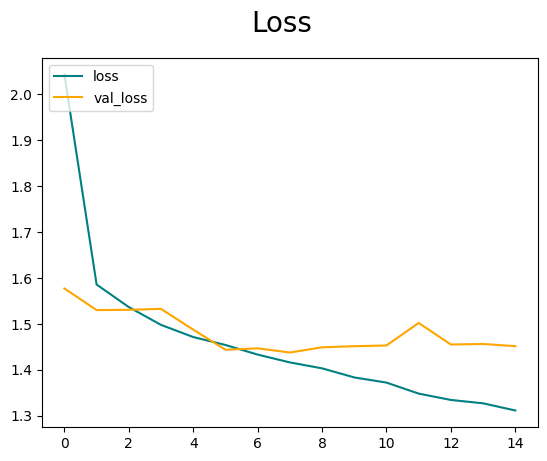

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

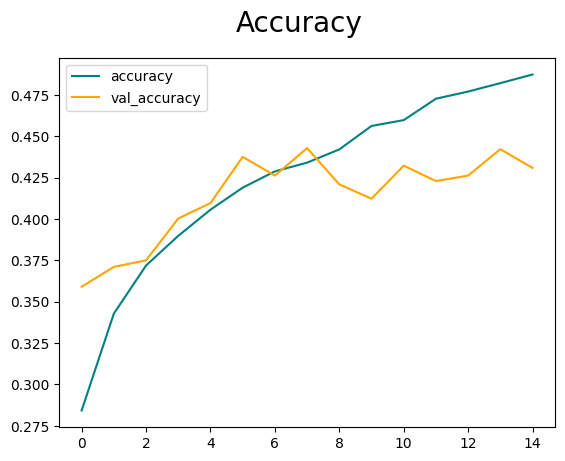

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
tf.keras.models.save_model(model,'/content/drive/MyDrive/Xception classifier.h5')